In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import Counter
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)
        
# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels


## 1. Nearest Neighbor 기반 평가
   - 각 이미지의 임베딩 계산
   - 각 이미지에 대해 다른 모든 이미지와의 코사인 유사도 계산
   - 유사도가 가장 높은 이미지의 레이블을 예측 레이블로 설정
   - 예츨 레이블이 실제 레이블과 일치하는지 확인해 분류 정확도 계산
  


Model: resnet18   
Accuracy: 0.5151515151515151   
Correct Classifications: 34   
Incorrect Classifications: 32   
Processing Time per Image: 0.04445436145320083   

Model: resnet50   
Accuracy: 0.4696969696969697   
Correct Classifications: 31   
Incorrect Classifications: 35   
Processing Time per Image: 0.0996213790142175   

Model: efficientnet_b0   
Accuracy: 0.3181818181818182   
Correct Classifications: 21   
Incorrect Classifications: 45   
Processing Time per Image: 0.04663918235085227   

Model: efficientnet_b7   
Accuracy: 0.4090909090909091   
Correct Classifications: 27   
Incorrect Classifications: 39   
Processing Time per Image: 0.2479026173100327   

In [ ]:
def classify_images(model_names, folder_path, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        # 올바르게 분류된 데이터 수 및 분류되지 않은 데이터 수 계산
        correct_classifications = 0
        incorrect_classifications = 0

        for i, embedding in enumerate(embeddings):
            similarities = []
            for j in range(len(images)):
                if i != j:
                    sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                    similarities.append((sim, labels[j]))

            # 유사도 기준으로 정렬
            similarities.sort(reverse=True, key=lambda x: x[0])

            # 가장 유사한 이미지와 해당 유사도 출력
            most_similar_label = similarities[0][1]

            # 분류 결과 확인
            if most_similar_label == labels[i]:
                correct_classifications += 1
            else:
                incorrect_classifications += 1

        # 정확도 계산
        total_images = correct_classifications + incorrect_classifications
        accuracy = correct_classifications / total_images

        results[model_name] = {
            'accuracy': accuracy,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Processing Time per Image: {result['processing_time']}")

## 2. Threshold 기반 평가
- 모든 이미지 간의 코사인 유사도 계산
- 동일한 레이블을 가진 이미지 쌍의 유사도가 주어진 임계값보다 높은지,
- 다른 레이블을 가진 이미지 쌍의 유사도가 주어진 임계값보다 낮은지 ⇒ 정확도 평가
- 각 임계값에서 모델의 정확도 평가, 그래프 시각화
- **efficient_b0 더 분석해보기

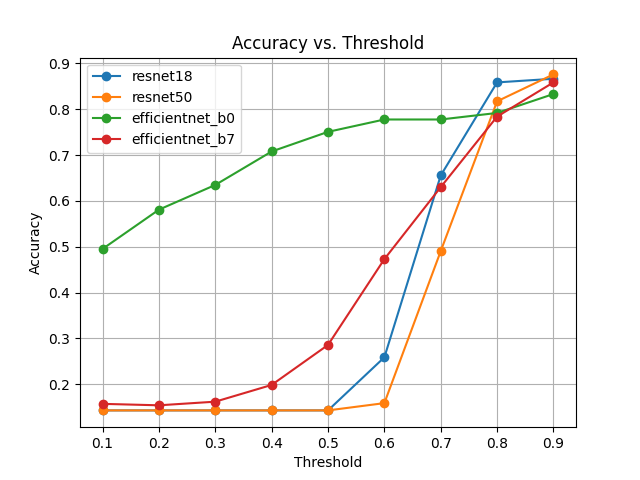

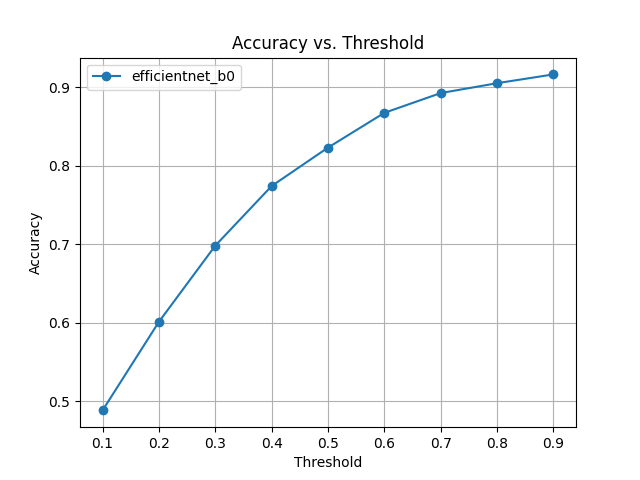

Evaluating model resnet18
Model: resnet18, Threshold: 0.1, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.2, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.30000000000000004, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.4, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.5, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.6, Accuracy: 0.25873015873015875
Model: resnet18, Threshold: 0.7000000000000001, Accuracy: 0.6555555555555556
Model: resnet18, Threshold: 0.8, Accuracy: 0.8587301587301587
Model: resnet18, Threshold: 0.9, Accuracy: 0.8666666666666667

Evaluating model resnet50
Model: resnet50, Threshold: 0.1, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.2, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.30000000000000004, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.4, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.5, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.6, Accuracy: 0.15873015873015872
Model: resnet50, Threshold: 0.7000000000000001, Accuracy: 0.49047619047619045
Model: resnet50, Threshold: 0.8, Accuracy: 0.8174603174603174
Model: resnet50, Threshold: 0.9, Accuracy: 0.8761904761904762

Evaluating model efficientnet_b0
Model: efficientnet_b0, Threshold: 0.1, Accuracy: 0.49523809523809526
Model: efficientnet_b0, Threshold: 0.2, Accuracy: 0.580952380952381
Model: efficientnet_b0, Threshold: 0.30000000000000004, Accuracy: 0.6349206349206349
Model: efficientnet_b0, Threshold: 0.4, Accuracy: 0.707936507936508
Model: efficientnet_b0, Threshold: 0.5, Accuracy: 0.7507936507936508
Model: efficientnet_b0, Threshold: 0.6, Accuracy: 0.7777777777777778
Model: efficientnet_b0, Threshold: 0.7000000000000001, Accuracy: 0.7777777777777778
Model: efficientnet_b0, Threshold: 0.8, Accuracy: 0.792063492063492
Model: efficientnet_b0, Threshold: 0.9, Accuracy: 0.8333333333333334

Evaluating model efficientnet_b7
Model: efficientnet_b7, Threshold: 0.1, Accuracy: 0.15714285714285714
Model: efficientnet_b7, Threshold: 0.2, Accuracy: 0.15396825396825398
Model: efficientnet_b7, Threshold: 0.30000000000000004, Accuracy: 0.1619047619047619
Model: efficientnet_b7, Threshold: 0.4, Accuracy: 0.1984126984126984
Model: efficientnet_b7, Threshold: 0.5, Accuracy: 0.2857142857142857
Model: efficientnet_b7, Threshold: 0.6, Accuracy: 0.473015873015873
Model: efficientnet_b7, Threshold: 0.7000000000000001, Accuracy: 0.6301587301587301
Model: efficientnet_b7, Threshold: 0.8, Accuracy: 0.7841269841269841
Model: efficientnet_b7, Threshold: 0.9, Accuracy: 0.8587301587301587

[train data 늘려서 실행했을때 결과]

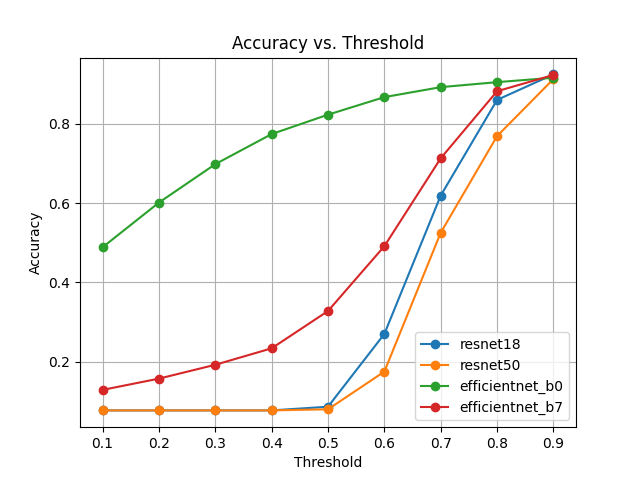

In [ ]:
# 주어진 임베딩(벡터)와 레이블 사용해 모델의 정확도 평가 - 유사도 임계값을 기준으로 올바르게 분류된 쌍의 비율을 계산
def evaluate_model(embeddings, labels, thresholds):
    results = []

    for threshold in thresholds:
        class_similarities = defaultdict(list)
        correct = 0
        total = 0

        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                if labels[i] == labels[j]:
                    class_similarities[labels[i]].append(sim)
                    if sim > threshold:
                        correct += 1
                else:
                    if sim <= threshold:
                        correct += 1
                total += 1

        accuracy = correct / total
        results.append((threshold, accuracy))
    return results


def plot_results(results, model_name):
    thresholds = [r[0] for r in results]
    accuracies = [r[1] for r in results]

    plt.plot(thresholds, accuracies, marker='o', label=model_name)

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.grid(True)

def main_evaluation():
    # 설정
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    folder_path = './data-gatter/train_L'
    cuda = torch.cuda.is_available()
    thresholds = np.arange(0.1, 1.0, 0.1)  # 다양한 임계값 설정

    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results_all_models = {}
    
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)

        # 성능 평가
        results = evaluate_model(embeddings, labels, thresholds)
        results_all_models[model_name] = results
        
        # 결과 출력
        for threshold, accuracy in results:
            print(f"Model: {model_name}, Threshold: {threshold}, Accuracy: {accuracy}")
        
        # 결과 그래프로 표시
        plot_results(results, model_name)
    
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main_evaluation()

## 3. Similarity Threshold 방법
* A 클래스의 이미지와 모든 이미지의 유사도를 계산한 후, 유사도 임계값(threshold)을 조정하여 동일한 클래스가 가장 많이 분류되고 다른 클래스가 가장 적게 분류되는 임계값을 찾습니다.
- 모든 이미지 간의 코사인 유사도 계산
- 다양한 임계값에 대해 유사도가 임계점보다 높은 이미지들 확인, 해당 이미지들의 클래스 조사
- 동일한 클래스가 가장 많이 분류 & 다른 클래스가 가장 적게 분류되는 임계점 찾기

Model: resnet18
Best Threshold: 0.9
Accuracy: 0.7352941176470589
Processing Time per Image: 0.04785397197261001

Model: resnet50
Best Threshold: 0.9
Accuracy: 0.5384615384615384
Processing Time per Image: 0.09950146530613754

Model: efficientnet_b0
Best Threshold: 0.9
Accuracy: 0.3333333333333333
Processing Time per Image: 0.04222954042030103

Model: efficientnet_b7
Best Threshold: 0.9
Accuracy: 0.5

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict, Counter
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def classify_images_with_best_threshold(model_names, folder_path, threshold_values, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        best_threshold = None
        best_accuracy = 0
        threshold_class_counts = {}

        for threshold in threshold_values:
            correct_classifications = 0
            incorrect_classifications = 0
            class_count = Counter()

            for i, embedding in enumerate(embeddings):
                similarities = []
                for j in range(len(images)):
                    if i != j:
                        sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                        if sim >= threshold:
                            similarities.append(labels[j])

                if similarities:
                    most_common_class = Counter(similarities).most_common(1)[0][0]
                    class_count[most_common_class] += 1
                    if most_common_class == labels[i]:
                        correct_classifications += 1
                    else:
                        incorrect_classifications += 1

            # 정확도 계산
            total_comparisons = correct_classifications + incorrect_classifications
            accuracy = correct_classifications / total_comparisons

            threshold_class_counts[threshold] = class_count

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold

        results[model_name] = {
            'best_threshold': best_threshold,
            'best_accuracy': best_accuracy,
            'processing_time': processing_time,
            'threshold_class_counts': threshold_class_counts
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    threshold_values = np.linspace(0.1, 0.9, 9)
    cuda = torch.cuda.is_available()

    results = classify_images_with_best_threshold(model_names, folder_path, threshold_values, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Best Threshold: {result['best_threshold']}")
        print(f"Accuracy: {result['best_accuracy']}")
        print(f"Processing Time per Image: {result['processing_time']}")

        # 각 임계점마다의 클래스 수 출력
#        for threshold, class_count in result['threshold_class_counts'].items():
#            print(f"\nThreshold: {threshold}")
#            for cls, count in class_count.items():
#                print(f"Class: {cls}, Count: {count}")


## ~~4. Leave-One-Out Cross Similarity 방법~~
- ( N개의 이미지를 각각 자신을 제외한 N-1개의 이미지와 비교하여 동일 클래스와 다른 클래스의 분류 개수를 파악 )
- 각 이미지를 나머지 모든 이미지와의 유사도 계산
- 가장 유사한 이미지의 레이블이 같은지 여부 확인 -> 정확도 계산
=> 1번과 같음!!!!

Model: resnet18   
Accuracy: 0.5151515151515151   
Correct Classifications: 34   
Incorrect Classifications: 32   
Processing Time per Image: 0.041878638845501526   

Model: resnet50   
Accuracy: 0.4696969696969697   
Correct Classifications: 31   
Incorrect Classifications: 35   
Processing Time per Image: 0.11393329952702377   

Model: efficientnet_b0   
Accuracy: 0.3181818181818182   
Correct Classifications: 21   
Incorrect Classifications: 45   
Processing Time per Image: 0.046164574045123474   

Model: efficientnet_b7   
Accuracy: 0.4090909090909091   
Correct Classifications: 27   
Incorrect Classifications: 39   
Processing Time per Image: 0.21615313761162036   

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
import os
import ssl
import certifi

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def classify_images(model_names, folder_path, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        # 동일 클래스와 다른 클래스의 분류 개수 계산
        correct_classifications = 0
        incorrect_classifications = 0

        for i, embedding in enumerate(embeddings):
            for j in range(len(images)):
                if i != j:
                    sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                    if labels[i] == labels[j]:
                        if sim > 0.5:  # 임계값 0.5 기준으로 동일 클래스를 올바르게 분류
                            correct_classifications += 1
                        else:  # 동일 클래스인데 임계값 이하인 경우
                            incorrect_classifications += 1
                    else:
                        if sim <= 0.5:  # 임계값 0.5 이하로 다른 클래스를 올바르게 분류
                            correct_classifications += 1
                        else:  # 다른 클래스인데 임계값 초과인 경우
                            incorrect_classifications += 1

        # 정확도 계산
        total_images = correct_classifications + incorrect_classifications
        accuracy = correct_classifications / total_images

        results[model_name] = {
            'accuracy': accuracy,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Processing Time per Image: {result['processing_time']}")


## 5. K-Nearest Neighbors (KNN) 방법:
- 각 이미지에 대해 k개의 가장 가까운(유사도가 높은) 이미지를 찾습니다.
- 각 이미지의 k개의 이웃이 동일 클래스인지 확인하여 정확도를 평가합니다.
- k값을 조정하면서 최적의 k를 찾을 수 있습니다.
- ** cross-validation 사용 : 모델 평가 시 훈련데이터 사용하지 않도록! **

Model: resnet18   
Best K: 5   
Accuracy: 0.5454545454545454   
Processing Time per Image: 0.04402306585600882 seconds   
Correct Classifications: 23   
Incorrect Classifications: 43   

Model: resnet50   
Best K: 1   
Accuracy: 0.4696969696969697   
Processing Time per Image: 0.09807787880753026 seconds   
Correct Classifications: 20   
Incorrect Classifications: 46   

Model: efficientnet_b0   
Best K: 7   
Accuracy: 0.36363636363636365   
Processing Time per Image: 0.050465728297378075 seconds   
Correct Classifications: 18   
Incorrect Classifications: 48   

Model: efficientnet_b7   
Best K: 1   
Accuracy: 0.4090909090909091   
Processing Time per Image: 0.257330060005188 seconds   
Correct Classifications: 16   
Incorrect Classifications: 50   

In [ ]:
def knn_classify(embeddings, labels, query_embedding, k):
    # embeddings와 query_embedding 간의 유사도 계산
    similarities = [cosine_similarity([query_embedding], [embedding])[0][0] for embedding in embeddings]
    
    # 유사도와 레이블을 함께 저장
    similarity_label_pairs = list(zip(similarities, labels))
    
    # 유사도 기준으로 내림차순 정렬
    similarity_label_pairs.sort(reverse=True, key=lambda x: x[0])
    
    # k개의 가장 유사한 이웃 선택
    nearest_neighbors = similarity_label_pairs[:k]
    
    # 가장 많이 등장한 레이블 선택
    neighbor_labels = [label for _, label in nearest_neighbors]
    most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
    
    return most_common_label

def classify_images_knn(model_names, folder_path, k_values, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        best_accuracy = 0
        best_k = None
        for k in k_values:
            # KNN 알고리즘을 사용하여 분류
            correct_classifications = 0
            incorrect_classifications = 0

            for i, query_embedding in enumerate(embeddings):
                # Leave-one-out 방식으로 평가
                leave_out_embeddings = np.delete(embeddings, i, axis=0)
                leave_out_labels = np.delete(labels, i, axis=0)
                
                predicted_label = knn_classify(leave_out_embeddings, leave_out_labels, query_embedding, k)
                
                if predicted_label == labels[i]:
                    correct_classifications += 1
                else:
                    incorrect_classifications += 1

            # 정확도 계산
            total_images = correct_classifications + incorrect_classifications
            accuracy = correct_classifications / total_images

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k = k

        results[model_name] = {
            'best_k': best_k,
            'best_accuracy': best_accuracy,
            'processing_time': processing_time,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    k_values = [1, 3, 5, 7, 9, 11, 13, 15]
    cuda = torch.cuda.is_available()

    results = classify_images_knn(model_names, folder_path, k_values, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Best K: {result['best_k']}")
        print(f"Accuracy: {result['best_accuracy']}")
        print(f"Processing Time per Image: {result['processing_time']} seconds")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")


## 6. Confusion Matrix 방법
- 모든 이미지 쌍에 대해 유사도를 계산
- 유사도 기준으로 예측된 클래스와 실제 클래스를 비교하여 혼동 행렬(confusion matrix) 작성
- 이 혼동 행렬을 통해 각 클래스별로 얼마나 정확하게 분류되었는지를 분석 가능

[[ 결과 분석 ]]
1. 정확도 (Accuracy)
* 정의: 전체 데이터 중에서 모델이 올바르게 예측한 비율입니다.
* 계산식: (TP + TN) / (TP + TN + FP + FN)
* 해석: 전체적인 성능을 한눈에 보여주지만, 클래스 불균형 문제에 취약할 수 있습니다.

2. 정밀도 (Precision)
* 정의: 모델이 긍정으로 예측한 샘플 중에서 실제로 긍정인 샘플의 비율입니다.
* 계산식: TP / (TP + FP)
* 해석: 정밀도는 긍정 예측의 정확도를 측정합니다. 정밀도가 높다는 것은 모델이 긍정 예측을 신뢰할 수 있음을 의미합니다.

3. 재현율 (Recall)
* 정의: 실제 긍정인 샘플 중에서 모델이 올바르게 긍정으로 예측한 샘플의 비율입니다.
* 계산식: TP / (TP + FN)
* 해석: 재현율은 모델이 실제 긍정 샘플을 얼마나 잘 찾아내는지를 측정합니다. 재현율이 높다는 것은 모델이 긍정 샘플을 놓치지 않는다는 것을 의미합니다.

4. F1-score
* 정의: 정밀도와 재현율의 조화 평균입니다.
* 계산식: 2 * (Precision * Recall) / (Precision + Recall)
* 해석: 정밀도와 재현율 간의 균형을 제공합니다. 특히 클래스 불균형 문제에서 유용합니다. F1-score가 높을수록 모델의 전반적인 성능이 좋음을 의미합니다.

5. 처리 시간 (Processing Time)
* 정의: 모델이 하나의 이미지를 처리하고 예측하는 데 걸리는 평균 시간입니다.
* 측정 방법: 전체 처리 시간을 이미지 수로 나누어 계산합니다.
* 해석: 처리 시간이 짧을수록 모델의 실시간 응답성이 좋음을 의미합니다. 모델의 실용성을 평가할 때 중요한 지표입니다.


#### [ 가장 높은 유사도 가진 이미지의 클래스로 지정 -> 이때의 모델 평가 ]  
Model: resnet18   
Confusion Matrix:   
[[4 0 0 0 1 0 0 0 0 1 0]   
 [0 5 0 0 0 0 0 0 0 1 0]   
 [1 0 2 0 1 0 1 1 0 0 0]   
 [1 1 0 2 0 0 0 0 0 2 0]   
 [3 0 1 0 0 0 0 0 0 2 0]   
 [0 0 0 0 0 4 0 0 0 2 0]   
 [0 0 3 1 0 0 2 0 0 0 0]   
 [1 0 0 0 0 0 0 4 0 0 1]   
 [0 0 0 0 0 0 0 0 5 0 1]   
 [1 1 0 0 1 1 0 0 0 2 0]   
 [0 0 0 0 0 1 0 0 1 0 4]]   
 
Classification Report:  
 
               precision    recall  f1-score   support

        BOLD       0.36      0.67      0.47         6
      BUBBLE       0.71      0.83      0.77         6
        BURR       0.33      0.33      0.33         6
      DAMAGE       0.67      0.33      0.44         6
        DUST       0.00      0.00      0.00         6
        FOLD       0.67      0.67      0.67         6
        LINE       0.67      0.33      0.44         6
       REACT       0.80      0.67      0.73         6
        RING       0.83      0.83      0.83         6
     SCRATCH       0.20      0.33      0.25         6
         TIP       0.67      0.67      0.67         6

    accuracy                           0.52        66
    macro avg      0.54      0.52      0.51        66
    weighted avg   0.54      0.52      0.51        66

Processing Time per Image: 0.043886058258287834   

Model: resnet50   
Confusion Matrix:   
[[3 0 1 0 0 1 0 0 0 1 0]   
 [0 5 0 0 0 1 0 0 0 0 0]      
 [1 0 1 0 2 0 0 0 0 0 2]      
 [1 0 0 4 0 1 0 0 0 0 0]   
 [2 0 1 0 1 0 0 0 0 2 0]   
 [3 0 0 0 0 1 0 0 0 1 1]   
 [0 0 2 0 0 0 2 0 0 0 2]   
 [1 0 0 0 0 0 0 4 1 0 0]   
 [0 0 0 0 0 0 0 0 5 0 1]   
 [1 0 0 0 2 1 0 0 0 2 0]   
 [0 0 0 0 0 1 1 0 1 0 3]]   

Classification Report:  

              precision    recall  f1-score   support

        BOLD       0.25      0.50      0.33         6
      BUBBLE       1.00      0.83      0.91         6
        BURR       0.20      0.17      0.18         6
      DAMAGE       1.00      0.67      0.80         6
        DUST       0.20      0.17      0.18         6
        FOLD       0.17      0.17      0.17         6
        LINE       0.67      0.33      0.44         6
       REACT       1.00      0.67      0.80         6
        RING       0.71      0.83      0.77         6
     SCRATCH       0.33      0.33      0.33         6
         TIP       0.33      0.50      0.40         6

    accuracy                           0.47        66
    macro avg      0.53      0.47      0.48        66
    weighted avg   0.53      0.47      0.48        66

Processing Time per Image: 0.08918571472167969   

Model: efficientnet_b0   
Confusion Matrix:   
[[2 0 1 0 1 1 0 0 0 1 0]   
 [0 3 0 0 2 0 0 0 0 1 0]   
 [3 0 1 0 0 1 1 0 0 0 0]   
 [1 1 0 2 1 0 0 0 0 1 0]   
 [1 1 1 1 0 0 0 1 0 0 1]   
 [1 0 0 0 1 2 0 0 0 1 1]   
 [0 0 1 1 1 0 2 0 0 0 1]   
 [1 0 0 1 0 0 0 4 0 0 0]   
 [0 0 1 0 0 0 0 0 5 0 0]   
 [1 2 0 1 1 1 0 0 0 0 0]   
 [0 0 1 0 1 3 1 0 0 0 0]]   

Classification Report:   

              precision    recall  f1-score   support

        BOLD       0.20      0.33      0.25         6
      BUBBLE       0.43      0.50      0.46         6
        BURR       0.17      0.17      0.17         6
      DAMAGE       0.33      0.33      0.33         6
        DUST       0.00      0.00      0.00         6
        FOLD       0.25      0.33      0.29         6
        LINE       0.50      0.33      0.40         6
       REACT       0.80      0.67      0.73         6
        RING       1.00      0.83      0.91         6
     SCRATCH       0.00      0.00      0.00         6
         TIP       0.00      0.00      0.00         6

    accuracy                           0.32        66  
    macro avg      0.33      0.32      0.32        66  
    weighted avg   0.33      0.32      0.32        66  

Processing Time per Image: 0.04339884989189379   

Model: efficientnet_b7   
Confusion Matrix:   
[[1 0 1 0 2 2 0 0 0 0 0]   
 [0 4 0 0 0 0 0 0 0 1 1]   
 [0 0 2 0 0 0 2 1 0 0 1]   
 [1 0 0 3 0 0 0 0 0 2 0]   
 [1 0 1 0 1 0 1 0 0 2 0]   
 [0 0 0 0 0 6 0 0 0 0 0]   
 [0 0 2 0 1 1 0 0 1 1 0]   
 [0 0 1 0 1 0 0 4 0 0 0]   
 [0 0 0 0 0 0 0 0 5 0 1]   
 [0 0 0 2 1 0 1 0 1 1 0]   
 [0 1 1 0 1 2 0 0 1 0 0]]   

Classification Report:

              precision    recall  f1-score   support

        BOLD       0.33      0.17      0.22         6
      BUBBLE       0.80      0.67      0.73         6
        BURR       0.25      0.33      0.29         6
      DAMAGE       0.60      0.50      0.55         6
        DUST       0.14      0.17      0.15         6
        FOLD       0.55      1.00      0.71         6
        LINE       0.00      0.00      0.00         6
       REACT       0.80      0.67      0.73         6
        RING       0.62      0.83      0.71         6
     SCRATCH       0.14      0.17      0.15         6
         TIP       0.00      0.00      0.00         6

    accuracy                           0.41        66
    macro avg      0.39      0.41      0.39        66
    weighted avg   0.39      0.41      0.39        66

Processing Time per Image: 0.19950371438806708      

[[ 모델별 성능 분석 ]]   
**ResNet18**   
정확도: 52%   
정밀도, 재현율, F1-score:   
BUBBLE: Precision 0.71, Recall 0.83, F1-score 0.77   
DUST: Precision 0.00, Recall 0.00, F1-score 0.00   
RING: Precision 0.83, Recall 0.83, F1-score 0.83   
다른 클래스들은 전반적으로 고르지 않은 성능을 보임   
처리 시간: 0.0439초   
해석: 전반적으로 고른 성능을 보이며, BUBBLE, REACT, RING 클래스에서 높은 성능을 보임. DUST 클래스에서는 전혀 분류되지 않음.   

**ResNet50**  
정확도: 47%   
정밀도, 재현율, F1-score:   
BUBBLE: Precision 1.00, Recall 0.83, F1-score 0.91   
DUST: Precision 0.20, Recall 0.17, F1-score 0.18   
RING: Precision 0.71, Recall 0.83, F1-score 0.77   
BURR: Precision 0.20, Recall 0.17, F1-score 0.18   
처리 시간: 0.0892초   
해석: BUBBLE, REACT, RING 클래스에서 높은 성능을 보이나, 전체적으로 낮은 성능을 보임. 클래스 불균형 문제를 겪고 있음.   

**EfficientNet B0**  
정확도: 32%   
정밀도, 재현율, F1-score:   
RING: Precision 1.00, Recall 0.83, F1-score 0.91   
DUST, SCRATCH, TIP: Precision 0.00, Recall 0.00, F1-score 0.00   
BUBBLE: Precision 0.43, Recall 0.50, F1-score 0.46   
처리 시간: 0.0434초   
해석: 낮은 정확도를 보이며, DUST, SCRATCH, TIP 클래스에서 전혀 분류되지 않음. 전반적으로 성능이 좋지 않음.   

**EfficientNet B7**  
정확도: 41%   
정밀도, 재현율, F1-score:   
FOLD: Precision 0.55, Recall 1.00, F1-score 0.71   
REACT: Precision 0.80, Recall 0.67, F1-score 0.73   
LINE, TIP: Precision 0.00, Recall 0.00, F1-score 0.00   
RING: Precision 0.62, Recall 0.83, F1-score 0.71   
처리 시간: 0.1995초   
해석: FOLD, REACT, RING 클래스에서 높은 성능을 보임. 하지만 LINE, TIP 클래스에서 전혀 분류되지 않음. 처리 시간이 길어 실시간 응답성은 낮음.   

### 결론 
- *ResNet18이 전반적으로 가장 높은 성능과 빠른 처리 시간을 보이며, 고른 성능을 보임.*   
- *특정 클래스에서 높은 성능이 필요한 경우, ResNet50이나 EfficientNet B7을 고려할 수 있음.*   
- *EfficientNet B0는 전반적으로 낮은 성능을 보임.*   


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def classify_images(model_names, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    label_set = sorted(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(label_set)}

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        predicted_labels = []
        for i, embedding in enumerate(embeddings):
            similarities = []
            for j in range(len(images)):
                if i != j:
                    sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                    similarities.append((sim, labels[j]))

            similarities.sort(reverse=True, key=lambda x: x[0])
            most_similar_label = similarities[0][1]
            predicted_labels.append(most_similar_label)

        true_indices = [label_to_index[label] for label in labels]
        predicted_indices = [label_to_index[label] for label in predicted_labels]

        cm = confusion_matrix(true_indices, predicted_indices)
        report = classification_report(true_indices, predicted_indices, target_names=label_set)

        results[model_name] = {
            'confusion_matrix': cm,
            'classification_report': report,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Confusion Matrix:\n{result['confusion_matrix']}")
        print(f"Classification Report:\n{result['classification_report']}")
        print(f"Processing Time per Image: {result['processing_time']}")


## 7. Cluster Analysis 방법:

- 모든 이미지의 임베딩을 사용 -> 클러스터링 알고리즘(K-means, DBSCAN 등)적용
- 클러스터링 결과를 기반으로 동일 클래스의 이미지가 얼마나 동일한 클러스터에 속하는지를 평가
- 실루엣 점수(Silhouette Score)나 ARI (Adjusted Rand Index)와 같은 지표를 사용 가능


* k-means 클러스터링 수행 후, 클러스터 순도(purity) & 실루엣 점수(silhouette score) 계산
* purity : 각 클러스터가 얼마나 단일 클래스로 잘 분리되는지 나타냄
* silhouette score : 클러스터링의 전체 품질을 측정하는 지표. 
  * 값이 클수록 클러스터링 품질 좋음

Model: resnet18   
Purity: 0.5606060606060606   
Silhouette Score: 0.16100965440273285   
Processing Time per Image: 0.04474107424418131   

Model: resnet50   
Purity: 0.5   
Silhouette Score: 0.14578448235988617   
Processing Time per Image: 0.08819015459580855   

Model: efficientnet_b0   
Purity: 0.3787878787878788   
Silhouette Score: 0.22547301650047302   
Processing Time per Image: 0.043679638342423874   

Model: efficientnet_b7   
Purity: 0.4090909090909091   
Silhouette Score: 0.13617292046546936   
Processing Time per Image: 0.2653715755000259  

* **ResNet18**은 비교적 높은 순도와 중간 정도의 실루엣 점수를 보이며, 효율적인 처리 시간을 가지고 있어 전반적으로 균형 잡힌 성능을 보입니다.
* **ResNet50**은 순도와 실루엣 점수에서 중간 정도의 성능을 보이며, 처리 시간이 ResNet18보다 약간 더 걸립니다.
* **fficientNet B0**는 가장 높은 실루엣 점수를 보이지만 순도가 낮아, 클러스터의 경계는 명확하지만 클러스터 내에서 클래스가 잘 분리되지 않는다는 것을 의미합니다. 처리 시간은 매우 빠릅니다.
* **EfficientNet B7**은 순도와 실루엣 점수 모두 낮고 처리 시간이 가장 오래 걸리는 모델로, 클러스터링 성능이 다른 모델에 비해 떨어집니다.
  
**결론**
- **ResNet18**이 전반적으로 가장 균형 잡힌 성능을 보여줍니다.
- **EfficientNet B0**는 클러스터 품질이 좋지만 클래스 구분이 덜 명확하여, 추가적인 튜닝이 필요할 수 있습니다.
- **EfficientNet B7**은 다른 모델들에 비해 성능이 떨어지며, 높은 계산 복잡도로 인해 실제 사용에 비효율적일 수 있습니다.


In [ ]:
from sklearn.metrics import silhouette_score

def cluster_images(model_names, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    label_to_index = {label: idx for idx, label in enumerate(set(labels))}
    numerical_labels = [label_to_index[label] for label in labels]

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        # K-means clustering
        kmeans = KMeans(n_clusters=len(set(labels)), random_state=0).fit(embeddings)
        cluster_labels = kmeans.labels_

        # Calculate purity
        cluster_to_labels = defaultdict(list)
        for cluster_label, true_label in zip(cluster_labels, numerical_labels):
            cluster_to_labels[cluster_label].append(true_label)

        correct_classifications = 0
        total_classifications = 0
        for cluster, true_labels in cluster_to_labels.items():
            most_common_label = max(set(true_labels), key=true_labels.count)
            correct_classifications += true_labels.count(most_common_label)
            total_classifications += len(true_labels)

        purity = correct_classifications / total_classifications

        # Calculate silhouette score
        silhouette_avg = silhouette_score(embeddings, cluster_labels)

        results[model_name] = {
            'purity': purity,
            'silhouette_score': silhouette_avg,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = cluster_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Purity: {result['purity']}")
        print(f"Silhouette Score: {result['silhouette_score']}")
        print(f"Processing Time per Image: {result['processing_time']}")


## 8. Pairwise Similarity Distribution 방법:
- 동일 클래스 내의 이미지 쌍과 서로 다른 클래스 간의 이미지 쌍에 대해 유사도 분포 구하기
- 동일 클래스와 다른 클래스의 유사도 분포가 얼마나 분리되는지를 분석
  - ROC 곡선(Receiver Operating Characteristic Curve)과 AUC (Area Under the Curve) 값 통해 평가 가능



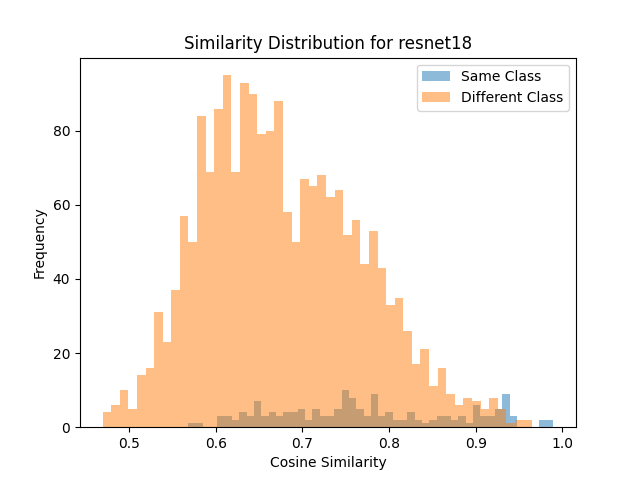
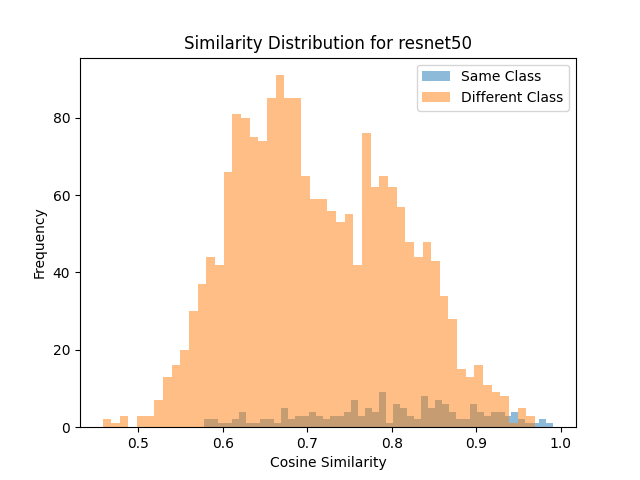
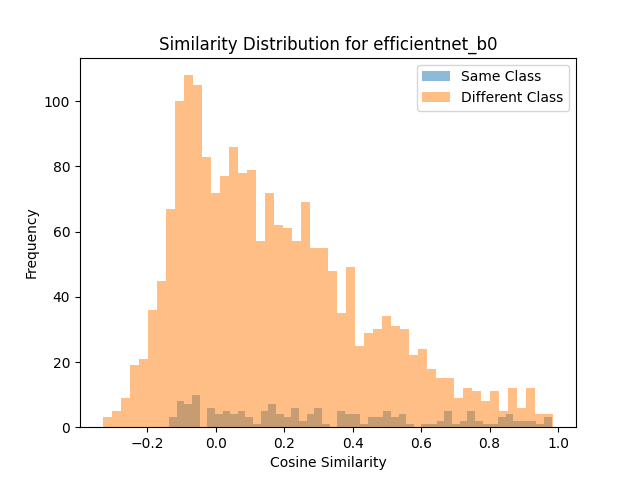
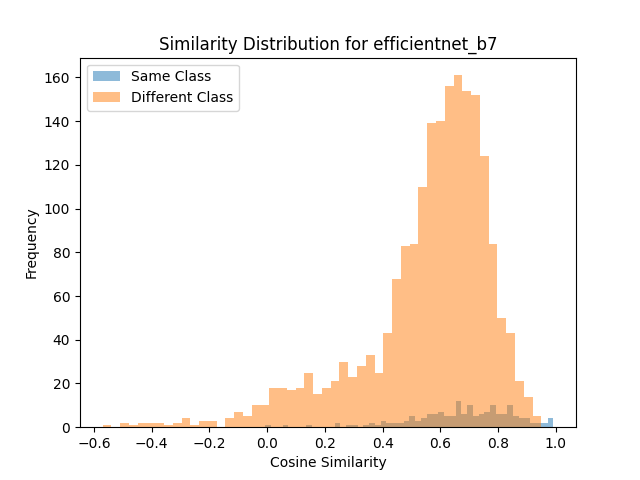


**ResNet18**
- 동일 클래스 간의 유사도가 다른 클래스 간의 유사도 보다 약간 더 높음 
- but 두 분포가 겹치는 부분이 많아 정확도 떨어질 가능성

**ResNet50**
- RestNet18과 유사한 결과

**EfficientNet B0**
- 동일 클래스 간 유사도가 상대적으로 낮음
- 두 분포가 많이 겹쳐 있음
- => 분류 정확도 낮음

**EfficientNet B7**
- 동일 클래스 간 유사도가 매우 높음(유사도 0.9이상에서 피크)
- 다른 클래스 유사도 분포(유사도 0.6 ~ 0.8에서 피크)보다 훨씬 높음
- => 분류 정확도 높은 가능성 큼

In [ ]:
import matplotlib.pyplot as plt

# Pairwise Similarity Distribution 계산
def pairwise_similarity_distribution(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                same_class_sims.append(sim)
            else:
                diff_class_sims.append(sim)
    
    return same_class_sims, diff_class_sims

# 히스토그램 그리기
def plot_similarity_distribution(same_class_sims, diff_class_sims, model_name):
    plt.hist(same_class_sims, bins=50, alpha=0.5, label='Same Class')
    plt.hist(diff_class_sims, bins=50, alpha=0.5, label='Different Class')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title(f'Similarity Distribution for {model_name}')
    plt.legend()
    plt.show()

def classify_images(model_names, folder_path, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        # Pairwise Similarity Distribution 계산
        same_class_sims, diff_class_sims = pairwise_similarity_distribution(embeddings, labels)

        # 히스토그램 그리기
        plot_similarity_distribution(same_class_sims, diff_class_sims, model_name)

        results[model_name] = {
            'same_class_sims': same_class_sims,
            'diff_class_sims': diff_class_sims,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train_L'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Processing Time per Image: {result['processing_time']}")


## 9. Metric Learning 방법:
- 트리플렛 손실(Triplet Loss) or 콘트라스트 손실(Contrastive Loss)을 사용 ->  임베딩 공간 학습
- 학습된 임베딩 공간에서 동일 클래스와 다른 클래스의 유사도 분포 평가